# Transformer






In [195]:
import torch
eigenmodel_path = "/root/eigenestimation/outputs/eigenmodels/tinystories-8M.pt"
eigenmodel = torch.load(eigenmodel_path)['model']
from eigenestimation.evaluation.top_logits import compute_jacobian

In [205]:
for circuit_idx in [1,2,3]:
    print(f'Circuit {circuit_idx}')
    jac = compute_jacobian(eigenmodel, X_data[[0]].to('cuda'), circuit_idx, device='cuda')
    top_token_idxs = jac.argsort(descending=True)[:5]
    bottom_token_idxs = jac.argsort(descending=False)[:5]
    print([eigenmodel.model.tokenizer.decode(token_idx) for token_idx in top_token_idxs])
    print([eigenmodel.model.tokenizer.decode(token_idx) for token_idx in bottom_token_idxs])


Circuit 1
["'s", ' was', ' is', '�', ' means']
[' day', ' night', ' dog', ' way', ' idea']
Circuit 2


[' day', ' idea', ' dog', ' little', ' are']
[' was', ' is', "'s", ' way', ' means']
Circuit 3
[' day', ' night', ' morning', ' week', ' days']
[' is', "'s", ' was', ' bird', ' dog']


In [47]:
eigenmodel.param_dict

{'transformer.transformer.h.1.attn.attention.k_proj.weight': tensor([[-0.0338, -0.0252,  0.0091,  ...,  0.0099,  0.0139, -0.0032],
         [ 0.0175, -0.0406, -0.0315,  ...,  0.0334,  0.0150,  0.0046],
         [-0.0164,  0.0018,  0.0066,  ...,  0.0130,  0.0117,  0.0334],
         ...,
         [-0.0261,  0.0261,  0.0139,  ..., -0.0219,  0.0126,  0.0231],
         [ 0.0158, -0.0214,  0.0439,  ...,  0.0158,  0.0313,  0.0215],
         [ 0.0038,  0.0075,  0.0423,  ..., -0.0036, -0.0116, -0.0154]],
        device='cuda:0'),
 'transformer.transformer.h.1.attn.attention.v_proj.weight': tensor([[ 0.0049, -0.0012, -0.0045,  ..., -0.0457,  0.0095,  0.0121],
         [ 0.0028, -0.0384, -0.0097,  ..., -0.0223,  0.0069,  0.0175],
         [ 0.0010,  0.0099,  0.0175,  ...,  0.0185, -0.0076,  0.0357],
         ...,
         [ 0.0132,  0.0298, -0.0010,  ...,  0.0012,  0.0392,  0.0103],
         [ 0.0092,  0.0058, -0.0124,  ...,  0.0094, -0.0018,  0.0116],
         [-0.0058, -0.0104, -0.0081,  ..., -

In [60]:
X_data_path = "/root/eigenestimation/outputs/top_tokens/tinystories-8M-X_data.pt"
attributions_path = "/root/eigenestimation/outputs/top_tokens/tinystories-8M-circuit_attributions.pt"
eigenmodel_path = "/root/eigenestimation/outputs/eigenmodels/tinystories-8M.pt"
X_data = torch.load(X_data_path)

In [148]:
import einops
from torch.func import functional_call
def reconstruct_network(eigenmodel, coef, sample, feature_idx) -> dict:
        original = eigenmodel.param_dict
        reconstruction = dict({})
        new_network = dict({})
        for name in eigenmodel.low_rank_decode:
            print(name)
            reconstruction[name] = eigenmodel.low_rank_decode[name][0][...,feature_idx]
            for tensor in eigenmodel.low_rank_decode[name][1:]:
                reconstruction[name] = einops.einsum(reconstruction[name], tensor[...,feature_idx], '... r, w r ->  ... w r')
            reconstruction[name] = einops.einsum(reconstruction[name], '... w r  -> ... w')
            new_network[name] = coef* reconstruction[name]
        return functional_call(eigenmodel.model, new_network, sample)

In [140]:
grad_outputs

NameError: name 'grad_outputs' is not defined

In [155]:
import torch

import einops
from torch.func import functional_call
def reconstruct_network(eigenmodel, coef, sample, feature_idx) -> dict:
        original = eigenmodel.param_dict
        reconstruction = dict({})
        new_network = dict({})
        for name in eigenmodel.low_rank_decode:
            print(name)
            reconstruction[name] = eigenmodel.low_rank_decode[name][0][...,feature_idx]
            for tensor in eigenmodel.low_rank_decode[name][1:]:
                reconstruction[name] = einops.einsum(reconstruction[name], tensor[...,feature_idx], '... r, w r ->  ... w r')
            reconstruction[name] = einops.einsum(reconstruction[name], '... w r  -> ... w')
            new_network[name] = coef* reconstruction[name]
        return functional_call(eigenmodel.model, new_network, sample)

# Ensure coef is on the correct device
coef = torch.tensor(0.0, requires_grad=True, device='cuda')
token_idx = 0
# Compute softmax output
output_vals = reconstruct_network(eigenmodel, coef, (X_data[[0]].to('cuda'),), 2)[0, token_idx, :].softmax(dim=-1)[:10]

# Compute full Jacobian
jacobian = torch.autograd.functional.jacobian(lambda c: reconstruct_network(eigenmodel, c, (X_data[[0]].to('cuda'),), 2)[0, token_idx, :].softmax(dim=-1), coef)

# Print the Jacobian values
print("Full Jacobian:\n", jacobian)


transformer.transformer.h.1.attn.attention.k_proj.weight
transformer.transformer.h.1.attn.attention.v_proj.weight
transformer.transformer.h.1.attn.attention.q_proj.weight
transformer.transformer.h.1.attn.attention.k_proj.weight
transformer.transformer.h.1.attn.attention.v_proj.weight
transformer.transformer.h.1.attn.attention.q_proj.weight


KeyboardInterrupt: 

In [191]:
import top_logits


Full Jacobian:
 tensor([ 8.6503e-04,  1.5793e-04, -9.7902e-09,  ..., -1.8958e-09,
        -1.0279e-06,  3.3368e-05], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [184]:
jacobian.shape

torch.Size([100])

In [157]:
reconstruct_network(eigenmodel, coef, (X_data_cuda[[0]],), 2)

RuntimeError: shape '[1, 16, 16]' is invalid for input of size 16

In [154]:
output_vals.shape

torch.Size([10])

In [147]:
grads

(tensor(5.3364e-08, device='cuda:0'),)

In [142]:
grad_outputs

NameError: name 'grad_outputs' is not defined

In [125]:
v.grad

tensor(1., device='cuda:0')

In [37]:
self.param_dict

{'transformer.transformer.h.1.attn.attention.k_proj.weight': tensor([[-0.0338, -0.0252,  0.0091,  ...,  0.0099,  0.0139, -0.0032],
         [ 0.0175, -0.0406, -0.0315,  ...,  0.0334,  0.0150,  0.0046],
         [-0.0164,  0.0018,  0.0066,  ...,  0.0130,  0.0117,  0.0334],
         ...,
         [-0.0261,  0.0261,  0.0139,  ..., -0.0219,  0.0126,  0.0231],
         [ 0.0158, -0.0214,  0.0439,  ...,  0.0158,  0.0313,  0.0215],
         [ 0.0038,  0.0075,  0.0423,  ..., -0.0036, -0.0116, -0.0154]],
        device='cuda:0'),
 'transformer.transformer.h.1.attn.attention.v_proj.weight': tensor([[ 0.0049, -0.0012, -0.0045,  ..., -0.0457,  0.0095,  0.0121],
         [ 0.0028, -0.0384, -0.0097,  ..., -0.0223,  0.0069,  0.0175],
         [ 0.0010,  0.0099,  0.0175,  ...,  0.0185, -0.0076,  0.0357],
         ...,
         [ 0.0132,  0.0298, -0.0010,  ...,  0.0012,  0.0392,  0.0103],
         [ 0.0092,  0.0058, -0.0124,  ...,  0.0094, -0.0018,  0.0116],
         [-0.0058, -0.0104, -0.0081,  ..., -

In [3]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the dataset in streaming mode
dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)

# Initialize a tokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")  # Replace with your model
from transformer_lens.utils import tokenize_and_concatenate


class TinyStoriesIterableDataset(IterableDataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __iter__(self):
        for example in self.dataset:
            story = example["text"]  # TinyStories dataset has a 'text' column
            tokenized = tokenize_and_concatenate(story, self.tokenizer, max_length=self.max_length, add_bos_token=False)['tokens']
            yield tokenized



AttributeError: 'str' object has no attribute 'features'

In [1]:
from datasets import load_dataset
dataset = load_dataset('oscar', "unshuffled_deduplicated_en", split='train', streaming=True)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
shuffled_dataset = dataset.shuffle(buffer_size=100, seed=42)

tokenized_dataset = shuffled_dataset.map(lambda x: tokenizer(x["text"]), batched=True, batch_size=10)

for b in iter(tokenized_dataset):
    print(b)
    break

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1795 > 512). Running this sequence through the model will result in indexing errors


{'id': 8, 'text': "Delta may be known for its quiet streets and safe neighborhoods, but that's not an excuse for dismissing your auto insurance coverage. Whether your top priority is saving on your monthly expenses, creating stronger liability protections, or celebrating each year of safe driving with our Vanishing Deductible® program, Nationwide has what you're looking for. And if you're not sure what you're looking for, then talk to one of our Delta auto insurance agents about the right policy for you and your vehicle(s).\nNo matter what style of home you own in Delta, home insurance offers essential protection against a range of hazards. it's not just the dwelling, either. Nationwide also provides coverage for your belongings and liability concerns. Talk to one of our Delta home insurance agents about the different types of coverage that make sense for your homeowners policy.\nWe all worry about what will happen to our loved ones if something should happen to us. that's why every Na

In [2]:
tokenized_dataset

IterableDataset({
    features: Unknown,
    num_shards: 670
})

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
shuffled_dataset = dataset.shuffle(buffer_size=100, seed=42)

tokenized_dataset = shuffled_dataset.map(lambda x: tokenizer(x["text"]), batched=True, batch_size=10)

for b in iter(tokenized_dataset):
    print(b)
    break

In [ ]:
for _ in range(10):
    print(next(iter(shuffled_dataset))['text'])

In [25]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import gc
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation/eigenestimation')

from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
from eigenestimation.utils.uniform_models import ZeroOutput
from eigenestimation.toy_models.data import GenerateTMSInputs
from eigenestimation.toy_models.parallel_serial_network import CustomMLP
from torch import Tensor
import einops

from eigenestimation.utils.loss import MSELoss, MSEVectorLoss, KLDivergenceFlattenOverTokensLoss


import figure_names
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
from torch.utils.data import DataLoader
import gc

In [44]:
X_data_path = "/root/eigenestimation/outputs/top_tokens/tinystories-8M-X_data.pt"
attributions_path = "/root/eigenestimation/outputs/top_tokens/tinystories-8M-circuit_attributions.pt"
eigenmodel_path = "/root/eigenestimation/outputs/eigenmodels/tinystories-8M.pt"
X_data = torch.load(X_data_path)
attributions = torch.load(attributions_path)
eigenmodel = torch.load(eigenmodel_path)['model']
tokenizer = eigenmodel.model.tokenizer

In [45]:
circuit_idxs = range(len(attributions))
for circuit_idx in circuit_idxs:
    print('\n\n----- circuit_idx:', circuit_idx, 'activation:', attributions[circuit_idx]['activation'], '-----')
    for example in attributions[circuit_idx]['top_examples']:
        tokens = (X_data[example['sample_id']][:example['token_id']+1])
        text = tokenizer.decode(tokens.long())
        print(text.replace('\n', '\\newline'), '-->', example['value'])
#del X_data
#del attributions
#gc.collect()
#torch.cuda.empty_cache()




----- circuit_idx: 0 activation: 0.448 -----
\newlineThe end --> 14.932
. Everyone was so happy and the love --> 14.04
 scared. They do not know what to --> 13.848
. Wanna --> 13.596
 said.  --> 13.409


----- circuit_idx: 1 activation: 0.383 -----
\newlineThe end --> 18.447
. Wanna --> 16.664
 not listening to his owner. The end --> 14.378
 join them. They had a lot of --> 13.888
 her house, feeling very fancy. From --> 12.416


----- circuit_idx: 2 activation: 0.282 -----
, and the two of --> 13.014
 lady. --> 11.312
 asked her what was --> 9.97
 together. --> 8.711
 okay. --> 8.151


----- circuit_idx: 3 activation: 0.012 -----
 refuse them.Once upon --> 20.977
\newlineThe end.Once upon a time --> 19.115
 and fun!Once upon --> 18.295
 together.Once upon a time --> 17.409
 end.Once upon --> 16.752


----- circuit_idx: 4 activation: 0.401 -----
 where he was going and tri --> 15.072
 scared. They do not know what to --> 13.886
 One day, Lily was very excited because --> 13.596
 the 

NameError: name 'torch' is not defined

In [43]:
eigenmodel.low_rank_encode['transformer.transformer.h.1.attn.attention.k_proj.weight'][0].device

device(type='cuda', index=0)

In [ ]:

X_data_path


# Load tinystories data
token_length = 16
dataset = load_dataset('roneneldan/TinyStories', split="validation[:1%]")
X_train = tokenize_and_concatenate(dataset, tokenizer, max_length = token_length, add_bos_token=False)['tokens']
# Permute
X_transformer = X_train[torch.randperm(len(X_train)), :][:1000]
del X_train
del dataset


import torch


circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features
dataloader = DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True)


gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in :
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)
    

for i in circuit_vals.mean(dim=[0,1]).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs(abs_vals).flatten().argsort(descending=True)
    
    # Convert the flat indices back to (b, t) indices
    top_b, top_t = torch.div(top_indices, token_length, rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_b, top_t]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    sample_idxs_so_far = []
    for j in range(len(top_indices)):
        if top_b[j].item() in sample_idxs_so_far:
            continue
        if len(sample_idxs_so_far) >= 5:
            break
        sample_idxs_so_far.append(top_b[j].item())
        sample_idx = top_b[j].item()
        token_idx = top_t[j].item()
        tokens = X_ordered[sample_idx]
        tokens = tokens[:(token_idx+1)]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')




In [52]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import gc
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation/eigenestimation')

from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
from eigenestimation.utils.uniform_models import ZeroOutput
from eigenestimation.toy_models.data import GenerateTMSInputs
from eigenestimation.toy_models.parallel_serial_network import CustomMLP
from torch import Tensor
import einops

from eigenestimation.utils.loss import MSELoss, MSEVectorLoss, KLDivergenceFlattenOverTokensLoss


import figure_names
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
from torch.utils.data import DataLoader

eigenmodel_path = f"../outputs/eigenmodels/tinystories-8M.pt"
eigenmodel = torch.load(eigenmodel_path)['model']
tokenizer = eigenmodel.model.tokenizer
frac_activated = torch.load(eigenmodel_path)['frac_activated']


# Load tinystories data
token_length = 16
dataset = load_dataset('roneneldan/TinyStories', split="validation[:1%]")
X_train = tokenize_and_concatenate(dataset, tokenizer, max_length = token_length, add_bos_token=False)['tokens']
# Permute
X_transformer = X_train[torch.randperm(len(X_train)), :][:1000]
del X_train
del dataset


import torch


circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features
dataloader = DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True)


gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in :
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)
    

for i in circuit_vals.mean(dim=[0,1]).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs(abs_vals).flatten().argsort(descending=True)
    
    # Convert the flat indices back to (b, t) indices
    top_b, top_t = torch.div(top_indices, token_length, rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_b, top_t]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    sample_idxs_so_far = []
    for j in range(len(top_indices)):
        if top_b[j].item() in sample_idxs_so_far:
            continue
        if len(sample_idxs_so_far) >= 5:
            break
        sample_idxs_so_far.append(top_b[j].item())
        sample_idx = top_b[j].item()
        token_idx = top_t[j].item()
        tokens = X_ordered[sample_idx]
        tokens = tokens[:(token_idx+1)]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')




## Set up

In [112]:
eigenmodel_path = f"../outputs/eigenmodels/tinystories-8M.pt"
eigenmodel = torch.load(eigenmodel_path)['model']
tokenizer = eigenmodel.model.tokenizer
frac_activated = torch.load(eigenmodel_path)['frac_activated']


# Load tinystories data
token_length = 16
dataset = load_dataset('roneneldan/TinyStories', split="validation[:1%]")
X_train = tokenize_and_concatenate(dataset, tokenizer, max_length = token_length, add_bos_token=False)['tokens']
# Permute
X_transformer = X_train[torch.randperm(len(X_train)), :][:1000]
del X_train
del dataset


import torch


circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features
dataloader = DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True)


gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in :
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)
    

for i in circuit_vals.mean(dim=[0,1]).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs(abs_vals).flatten().argsort(descending=True)
    
    # Convert the flat indices back to (b, t) indices
    top_b, top_t = torch.div(top_indices, token_length, rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_b, top_t]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    sample_idxs_so_far = []
    for j in range(len(top_indices)):
        if top_b[j].item() in sample_idxs_so_far:
            continue
        if len(sample_idxs_so_far) >= 5:
            break
        sample_idxs_so_far.append(top_b[j].item())
        sample_idx = top_b[j].item()
        token_idx = top_t[j].item()
        tokens = X_ordered[sample_idx]
        tokens = tokens[:(token_idx+1)]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')



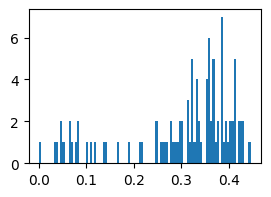

In [109]:
plt.figure(figsize=(3, 2))
plt.hist(frac_activated.detach().cpu().numpy(), bins=100)
plt.show()

In [110]:
for i in eigenmodel.low_rank_decode.values(): 
    for ii in i: 
        ii.requires_grad_(False)
for i in eigenmodel.low_rank_encode.values(): 
    for ii in i: 
        ii.requires_grad_(False)


In [56]:
# Load tinystories data
token_length = 16
dataset = load_dataset('roneneldan/TinyStories', split="validation[:1%]")
X_train = tokenize_and_concatenate(dataset, tokenizer, max_length = token_length, add_bos_token=False)['tokens']
# Permute
X_transformer = X_train[torch.randperm(len(X_train)), :][:1000]
del X_train
del dataset


import torch


circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features
dataloader = DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True)


gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in :
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)
    

for i in circuit_vals.mean(dim=[0,1]).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs(abs_vals).flatten().argsort(descending=True)
    
    # Convert the flat indices back to (b, t) indices
    top_b, top_t = torch.div(top_indices, token_length, rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_b, top_t]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    sample_idxs_so_far = []
    for j in range(len(top_indices)):
        if top_b[j].item() in sample_idxs_so_far:
            continue
        if len(sample_idxs_so_far) >= 5:
            break
        sample_idxs_so_far.append(top_b[j].item())
        sample_idx = top_b[j].item()
        token_idx = top_t[j].item()
        tokens = X_ordered[sample_idx]
        tokens = tokens[:(token_idx+1)]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')



In [113]:
circuit_vals = []
X_ordered = []
iters = 5
n_subnetworks = eigenmodel.n_features

dataloader = DataLoader(X_transformer[:100], batch_size=8, shuffle=False)
gc.collect()
torch.cuda.empty_cache()
for X_batch in dataloader:
    X_ordered.append(X_batch)
        # Compute gradients many times and take the average
    each_circuit_val = torch.zeros(X_batch.shape[0], n_subnetworks).to('cuda')
    for _ in range(iters):
        grads = eigenmodel.compute_gradients(X_batch.to('cuda'))
        each_circuit_val = each_circuit_val + (eigenmodel(grads))[:,:n_subnetworks]
        gc.collect()
        torch.cuda.empty_cache()
    circuit_vals.append(each_circuit_val.view(X_batch.shape[0], n_subnetworks))
circuit_vals = torch.concat(circuit_vals, dim=0)/iters
X_ordered = torch.concat(X_ordered, dim=0)

RuntimeError: The size of tensor a (8) must match the size of tensor b (128) at non-singleton dimension 0

In [16]:
token_eigenmodel = copy.deepcopy(eigenmodel)
token_eigenmodel.loss = KLDivergenceFlattenOverTokensLoss()

In [41]:
import torch

bold_idx = tokenizer.encode('***')

for i in circuit_vals.mean(dim=0).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs_vals.flatten().argsort(descending=True)[:5]
    
    # Convert the flat indices back to (b, t) indices
    #top_b, top_t = torch.div(top_indices, token_length, #rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_indices]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    for j in range(len(top_indices)):
        sample_idx = top_indices[j].item()
        tokens = X_ordered[sample_idx]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')




---- Feature 89 ---- Activation: 0.490
 leaves under her feet and tried to climb the icy hill again.=newline==newline=This time, Roxy didn't slip. She climbed and climbed until she reached the --> 3.75
. He did not take the shell from Mia. He found it in the sand. He did not want to make Mia angry.=newline==newline="No, Mia --> 2.57
Ben smiled and said, "Thank you, Mia. You are my sister. I love you too."Tom was a cat who liked to play outside. He --> 2.37
able friend to all the animals. He would stand by them and help them when they needed it. Everyone liked Sam because he was kind and strong.=newline==newline= --> 2.23
 them broke and spilled on the floor.=newline==newline="Oh no!" Tom and Anna said. They were scared. They heard their mom coming.=newline==newline=" --> 2.20


---- Feature 51 ---- Activation: 0.456
 farmer heard the cow. He wanted to help. So, he got another cow to be friends with the sad cow. The sad cow was happy now. They --> 2.60
 Lily's mom asked her if she wan

In [118]:
circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features
dataloader = DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True)


gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in :
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)

In [120]:
import torch


circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features
dataloader = DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True)


gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in :
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)
    

for i in circuit_vals.mean(dim=[0,1]).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs(abs_vals).flatten().argsort(descending=True)
    
    # Convert the flat indices back to (b, t) indices
    top_b, top_t = torch.div(top_indices, token_length, rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_b, top_t]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    sample_idxs_so_far = []
    for j in range(len(top_indices)):
        if top_b[j].item() in sample_idxs_so_far:
            continue
        if len(sample_idxs_so_far) >= 5:
            break
        sample_idxs_so_far.append(top_b[j].item())
        sample_idx = top_b[j].item()
        token_idx = top_t[j].item()
        tokens = X_ordered[sample_idx]
        tokens = tokens[:(token_idx+1)]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')




---- Feature 41 ---- Activation: 0.412
 Ben said.=newline= --> 28.08
=newline="No, go away. You are annoying," Lily said.=newline= --> 24.40
 and he fell in.=newline= --> 22.21
 and slippery, and they could see fish and plants under the ice.=newline= --> 21.56
 too. Do you want to play with me?"=newline==newline= --> 21.22


---- Feature 87 ---- Activation: 0.489
 big, hairy rabbit named --> 24.79
 Lily. --> 20.80
 okay, Lily. The sunset will come again tomorrow." Lily's mommy was --> 20.23
 tried again and again to squeeze the tap, but still no --> -19.83
 sorry for him. She said, --> 18.37


---- Feature 68 ---- Activation: 0.416
 Ben said.=newline==newline="Hi, Ben. Nice to meet --> 16.26
 try the bread. It --> -15.99
 big, hairy rabbit named --> -15.21
 clouds. They saw --> 15.20
 They  --> 14.30


---- Feature 42 ---- Activation: 0.410
 wet. He saw the stick, and grabbed it. Lily pulled him out of --> 20.45
 He loved to play with his ball in the --> 17.93
 sorry for him. She sai

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-8M')
for n,p in model.named_parameters(): print(n, p.shape, p.numel())

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/112M [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 256]) 12865792
transformer.wpe.weight torch.Size([2048, 256]) 524288
transformer.h.0.ln_1.weight torch.Size([256]) 256
transformer.h.0.ln_1.bias torch.Size([256]) 256
transformer.h.0.attn.attention.k_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.v_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.q_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.out_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.out_proj.bias torch.Size([256]) 256
transformer.h.0.ln_2.weight torch.Size([256]) 256
transformer.h.0.ln_2.bias torch.Size([256]) 256
transformer.h.0.mlp.c_fc.weight torch.Size([1024, 256]) 262144
transformer.h.0.mlp.c_fc.bias torch.Size([1024]) 1024
transformer.h.0.mlp.c_proj.weight torch.Size([256, 1024]) 262144
transformer.h.0.mlp.c_proj.bias torch.Size([256]) 256
transformer.h.1.ln_1.weight torch.Size([256]) 256
transformer.h.1.ln_1.bias torch.Size([256]

model.safetensors:   0%|          | 0.00/112M [00:00<?, ?B/s]